In [2]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pandas.plotting import lag_plot
import sklearn.linear_model
import time
%matplotlib inline

# Downloading data directly from Google

In [ ]:
'''
Follow directions here to create an API to access the data hosted on 
the drive: https://pythonhosted.org/PyDrive/quickstart.html

Once the client_secrets.json file is in ./Marin Workspace/ run the code 
below just once
'''
gauth = GoogleAuth()
gauth.LocalWebserverAuth()

In [ ]:
'''
Run the following code to download the data using the file's ID
'''
all_stocks_5yr = '1jpwvbmAjtqZJaRaTdJ4sWHyBDL6V8hzK'
drive = GoogleDrive(gauth)
data = drive.CreateFile({'id': all_stocks_5yr})
data.GetContentFile('all_stocks_5yr.csv')

# Load stock data and sector data

In [3]:
stock_data = pd.read_csv('all_stocks_5yr.csv', parse_dates = ['date'])#, index_col = 'Name')
sector_data = pd.read_csv('sectors.csv')#, index_col = 'Symbol')

In [4]:
stock_data.head(5)

,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL


In [5]:
sector_data.head(5)

,Symbol,Name,Sector
0,MMM,3M Company,Industrials
1,AOS,A.O. Smith Corp,Industrials
2,ABT,Abbott Laboratories,Health Care
3,ABBV,AbbVie Inc.,Health Care
4,ACN,Accenture plc,Information Technology


In [6]:
#Check for empty entries
stock_data.isnull().sum()

date       0
open      11
high       8
low        8
close      0
volume     0
Name       0
dtype: int64

In [7]:
#Check for empty entries
sector_data.isnull().sum()

Symbol    0
Name      0
Sector    0
dtype: int64

In [8]:
#Drop rows with empty values
stock_data.dropna(inplace = True) 

In [9]:
#Find the intersection of tickers between the two data sets
#Findings: there's missing data
stocks = set(stock_data.Name.unique())
sector = set(sector_data.Symbol.unique())

start = time.time()
intersection = [symbol for symbol in stocks if symbol in sector]
end = time.time()
print(len(intersection))
print(end-start)

start = time.time()
intersection = stocks.intersection(sector)
print(len(intersection))
end = time.time()
print(end-start)   

498
0.0004429817199707031
498
0.00029206275939941406


In [10]:
#Which stocks are missing from both data sets
stocks.symmetric_difference(sector)

{'BKNG',
 'CBG',
 'CBRE',
 'CHK',
 'HCN',
 'IPGP',
 'NKTR',
 'PCLN',
 'PDCO',
 'SIG',
 'SIVB',
 'SNI',
 'TTWO',
 'WELL'}

* CBG -> CBRE
* HCN -> WELL
* SNI -> AQUIRED BY Discovery Communications (Drop)
* CHK -> REMOVED DUE TO MARKET CAP CHANGES (Drop) Energy Company
* PDCO -> REMOVED DUE TO MARKET CAP CHANGES (Drop)
* SIG -> REMOVED DUE TO MARKET CAP CHANGES (Drop)
* PCLN -> no data (?)

In [11]:
#Create dictionary to replace old names with new
replace_tickers = {'CBG': 'CBRE', 'HCN': 'WELL'}
stock_data.replace(replace_tickers, inplace = True)

In [12]:
stock_data.set_index('Name', inplace = True)
sector_data.set_index('Symbol', inplace = True)

# Clean up and combine the two data sets 

In [30]:
#Combine the two dataframe's based off stock symbol (ticker)
df = pd.concat([stock_data, sector_data], axis = 1, join_axes=[stock_data.index])

#Rename the 'Name' column to 'full_name'
df.rename(columns={'Name':'full_name'}, inplace = True)

#Reset current index and change so that we're able to slice by time
df.reset_index(inplace = True)
df.set_index('date', inplace = True)

In [14]:
#Sanity check. There should be 11 sectors
len(list(df.groupby('Sector')))

11

In [49]:
df

,Name,open,high,low,close,volume,full_name,Sector
date,,,,,,,,
2013-02-08,AAL,15.07,15.1200,14.6300,14.75,8407500,American Airlines Group,Industrials
2013-02-11,AAL,14.89,15.0100,14.2600,14.46,8882000,American Airlines Group,Industrials
2013-02-12,AAL,14.45,14.5100,14.1000,14.27,8126000,American Airlines Group,Industrials
2013-02-13,AAL,14.30,14.9400,14.2500,14.66,10259500,American Airlines Group,Industrials
2013-02-14,AAL,14.94,14.9600,13.1600,13.99,31879900,American Airlines Group,Industrials
2013-02-15,AAL,13.93,14.6100,13.9300,14.50,15628000,American Airlines Group,Industrials
2013-02-19,AAL,14.33,14.5600,14.0800,14.26,11354400,American Airlines Group,Industrials
2013-02-20,AAL,14.17,14.2600,13.1500,13.33,14725200,American Airlines Group,Industrials
2013-02-21,AAL,13.62,13.9500,12.9000,13.37,11922100,American Airlines Group,Industrials


In [15]:
#Check for missing data
#8813
df.isnull().sum()

Name            0
open            0
high            0
low             0
close           0
volume          0
full_name    6295
Sector       6295
dtype: int64

In [28]:
df.index

Index(['AAL', 'AAL', 'AAL', 'AAL', 'AAL', 'AAL', 'AAL', 'AAL', 'AAL', 'AAL',
       ...
       'ZTS', 'ZTS', 'ZTS', 'ZTS', 'ZTS', 'ZTS', 'ZTS', 'ZTS', 'ZTS', 'ZTS'],
      dtype='object', name='Name', length=612734)

In [17]:
#Drop missing rows
df.dropna(inplace = True)

In [18]:
df['2016'].groupby('Sector').close.mean() - df['2013'].groupby('Sector').close.mean()

Sector
Consumer Discretionary        21.488716
Consumer Staples              22.109677
Energy                        -8.778538
Financials                    10.252233
Health Care                   36.125196
Industrials                   20.688022
Information Technology        31.142044
Materials                     14.759770
Real Estate                   24.775160
Telecommunication Services    -0.160739
Utilities                     11.867314
Name: close, dtype: float64

In [19]:
df2016 = df['2016']
print(df2016[df2016['Sector'] == 'Energy'].full_name.unique())

df2013 = df['2013']
print(df2013[df2013['Sector'] == 'Energy'].full_name.unique())

['Andeavor' 'Apache Corporation' 'Anadarko Petroleum Corp'
 'Cabot Oil & Gas' 'ConocoPhillips' 'Chevron Corp.' 'Concho Resources'
 'Devon Energy Corp.' 'EOG Resources' 'EQT Corporation' 'TechnipFMC'
 'Halliburton Co.' 'Hess Corporation' 'Helmerich & Payne' 'Kinder Morgan'
 'Marathon Petroleum' 'Marathon Oil Corp.' 'Noble Energy Inc'
 'Newfield Exploration Co' 'National Oilwell Varco Inc.' 'ONEOK'
 'Occidental Petroleum' 'Phillips 66' 'Pioneer Natural Resources'
 'Range Resources Corp.' 'Schlumberger Ltd.' 'Valero Energy'
 'Williams Cos.' 'Cimarex Energy' 'Exxon Mobil Corp.']
['Andeavor' 'Apache Corporation' 'Anadarko Petroleum Corp'
 'Cabot Oil & Gas' 'ConocoPhillips' 'Chevron Corp.' 'Concho Resources'
 'Devon Energy Corp.' 'EOG Resources' 'EQT Corporation' 'TechnipFMC'
 'Halliburton Co.' 'Hess Corporation' 'Helmerich & Payne' 'Kinder Morgan'
 'Marathon Petroleum' 'Marathon Oil Corp.' 'Noble Energy Inc'
 'Newfield Exploration Co' 'National Oilwell Varco Inc.' 'ONEOK'
 'Occidental Petro

Text(0.5,1,'Average Close Price Changes 2016-2013')

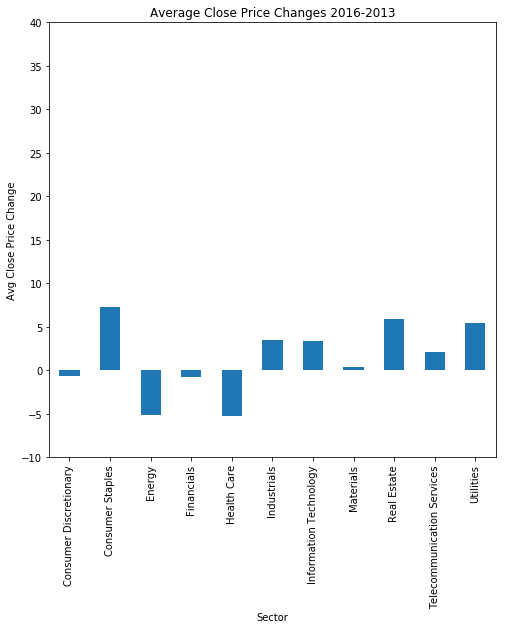

In [20]:
(df['2016'].groupby('Sector').close.mean() - df['2015'].groupby('Sector').close.mean()).plot(kind = 'bar',
                                                                                            yticks = np.arange(-10,41, 5),
                                                                                            figsize = (8,8))
plt.ylabel('Avg Close Price Change')
plt.title('Average Close Price Changes 2016-2013')


In [21]:
print(np.arange(-10,10))

[-10  -9  -8  -7  -6  -5  -4  -3  -2  -1   0   1   2   3   4   5   6   7
   8   9]


In [22]:
df2016 = df['2016']
energy_sector_companies = df2016[df2016['Sector'] == 'Energy']
#energy_close = energy_sector_companies.pct_change(axis='Name')
energy_open = energy_sector_companies.groupby('Name')['open']

#pct_change = (energy_close - energy_open)/energy_open


In [23]:
df.reset_index(inplace = True)
df.set_index('Name', inplace = True)

In [24]:
dfenergy.index.unique()[0]

NameError: name 'dfenergy' is not defined

In [ ]:
dfenergy = df[df.Sector == 'Energy']

for each in dfenergy.index.unique():
    print(dfenergy.iloc(each, 'close'))


In [ ]:
#Bar graph of mean close price for sectors
df.groupby('Sector').close.mean().plot(kind='bar', figsize = (8,8))

In [ ]:
#Bar graph of median close prices
df.groupby('Sector').close.median().plot(kind = 'bar', figsize = (8,8))

In [ ]:
sectors_and_companies = dict(df.groupby('Sector').full_name.unique())

In [ ]:
sectors_and_companies.keys()

In [ ]:
sum(map(len, sectors_and_companies.values()))

In [ ]:
list(map(len, sectors_and_companies.values()))

In [ ]:
sectors_and_companies.keys()
sectors_and_companies['Consumer Staples'][1]

In [27]:
df.index

Index(['AAL', 'AAL', 'AAL', 'AAL', 'AAL', 'AAL', 'AAL', 'AAL', 'AAL', 'AAL',
       ...
       'ZTS', 'ZTS', 'ZTS', 'ZTS', 'ZTS', 'ZTS', 'ZTS', 'ZTS', 'ZTS', 'ZTS'],
      dtype='object', name='Name', length=612734)

In [67]:
aapl_df = df[df['Name'] == 'AAPL']

X_train = (aapl_df.index - aapl_df.index[0]).days.values[0:629].reshape(-1,1)
y_train = aapl_df['close'].values[0:629].reshape(-1,1)

X_test = (aapl_df.index - aapl_df.index[0]).days.values[629:-1].reshape(-1,1)
y_test = aapl_df['close'].values[629:-1].reshape(-1,1)

lin_reg_model = sklearn.linear_model.LinearRegression()

lin_reg_model.fit(X_train, y_train)

#print(5000-1893)

#From 2-8-13 to 4-15-18: 1892 days
#lin_reg_model.predict()

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [71]:
((lin_reg_model.predict(X_test) - y_test)/y_test).mean()

0.36457012847965997

In [64]:
len((aapl_df.index - aapl_df.index[0]).days.values)

1259

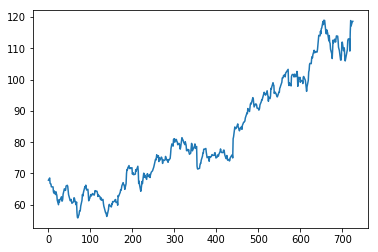

In [53]:
plt.plot(X,y)

In [ ]:
stock_data.reset_index(inplace = True)

In [ ]:
stock_data.set_index('date', inplace = True)

In [ ]:
sector_data.reset_index(inplace = True)

In [ ]:
df[df['Name'] == 'CHK']

In [ ]:
df.loc[:, df.Name == 'CBG'] = 'CBRE'

In [ ]:
df[df['Name'] == 'CBG']

In [ ]:
##### for row,column in sectors.iterrows():
#     for stock in stock_data.Name.unique():
#         if stock == column.Symbol:
#             print(stock, column.Name, column.Sector)

start = time.time()
for row1, column1 in sectors.iterrows():
    for row2, column2 in stock_data.iterrows():
        if column1.Symbol == column2.Name:
            column2.sector = column1.sector
            #print(column2.Name, column1.Name, column1.Sector)
end = time.time()
print(end-start)

In [ ]:
df['2018'].groupby('Sector').sum()